In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from sklearn import preprocessing
import math
from datetime import datetime
%matplotlib inline

In [7]:
data=pd.read_excel("card transactions.xlsx")
data=pd.DataFrame(data)

In [29]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0


# Remove outlier and all but type p

In [8]:
card=data[data.Transtype=="P"]
card=card[card.Recnum != 52715]

# Fill missing variables

## fill state

In [9]:
state_fill=card.groupby('Merch zip')['Merch state'].apply(lambda x:x.mode()).reset_index()
state_fill=state_fill[state_fill.level_1==1]
state_fill=state_fill.drop(columns=['level_1'])
state_fill.columns=["Merch zip","state fill"]
card=card.merge(state_fill,on="Merch zip", how='left')
card["Merch state"]=card["Merch state"].fillna(card['state fill']).fillna('TN')
card=card.drop(columns=['state fill'])

## fill Merch zip and Merchnum

In [10]:
card['Merch zip']=card.groupby(["Merch description"])['Merch zip'].apply(lambda x:x.fillna(x.median()))
card['Merch zip']=card.groupby(["Merch state"])['Merch zip'].apply(lambda x:x.fillna(x.median()))
card['Merch zip']=card['Merch zip'].fillna(38118)

In [11]:
merchnum_fill=card.groupby(["Merch description"])['Merchnum'].apply(lambda x:x.mode()).reset_index()
merchnum_fill=merchnum_fill[merchnum_fill.level_1 !=0]
merchnum_fill=merchnum_fill.drop(columns=['level_1'])
merchnum_fill.columns=["Merch description","merchnum_fill"]
card=card.merge(merchnum_fill,on="Merch description", how='left')
card["Merchnum"]=card["Merchnum"].fillna(card['merchnum_fill']).fillna('930090121224')
card=card.drop(columns=['merchnum_fill'])

# Variable Creation

In [12]:
card=pd.DataFrame.drop_duplicates(card)

## Create New variables

In [13]:
data_sorted=card
#Cardnum, Merchnum
for groupbyvar in ['Cardnum', 'Merchnum']:
    data_sorted = data_sorted.sort_values(by = [groupbyvar, 'Date'])
    data_sorted_index = data_sorted.set_index('Date')
    for agg in ['mean', 'max', 'median', 'sum', 'count']:
        for days in ['1d', '3d', '7d', '14d', '30d']:
            data_sorted[agg + '_' + groupbyvar + "_" + days]=getattr(data_sorted_index.groupby(groupbyvar)['Amount'].rolling(days),agg)().values
            data_sorted['Actual/' + agg + "_" + groupbyvar + "_" + days] = data_sorted['Amount']/data_sorted[agg + '_' + groupbyvar + "_" + days]

In [14]:
#Cardnum and Merchnum, Cardnum and Zip, Cardnum and state
for groupbyvar in ['Merchnum', 'Merch zip', 'Merch state']:
    data_sorted = data_sorted.sort_values(by = ['Cardnum',groupbyvar, 'Date'])
    data_sorted_index = data_sorted.set_index('Date')
    for agg in ['mean', 'max', 'median', 'sum', 'count']:
        for days in ['1d', '3d', '7d', '14d', '30d']:
            data_sorted[agg + '_' + "Cardnum_" + groupbyvar + "_" + days] = getattr(data_sorted_index.groupby(['Cardnum',groupbyvar])['Amount'].rolling(days),agg)().values
            data_sorted['Actual/' + agg + "_" + "Cardnum_" + groupbyvar + "_" + days] = data_sorted['Amount']/data_sorted[agg + '_' + "Cardnum_" + groupbyvar + "_" + days]

In [15]:
#Create days since variables
data_sorted1=data_sorted
for groupbyvar in [['Cardnum'], ['Merchnum'], ['Cardnum', 'Merchnum'], ['Cardnum', 'Merch zip'], ['Cardnum', 'Merch state']]:
    sortCols = groupbyvar[:]
    sortCols.append('Date')
    data_sorted1 = data_sorted1.sort_values(by = sortCols)
    if len(groupbyvar) == 1:
        data_sorted1['Days_since_per_' + groupbyvar[0]] = data_sorted1.groupby(groupbyvar)['Date'].apply(lambda x: (x - x.shift(1)).astype('timedelta64[D]')).fillna(365).values
    else:
        data_sorted1['Days_since_per_Cardnum_' + groupbyvar[1]] = data_sorted1.groupby(groupbyvar)['Date'].apply(lambda x: (x-x.shift(1)).astype('timedelta64[D]')).fillna(365).values

In [28]:
data_sorted1.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,Actual/count_Cardnum_Merch state_7d,count_Cardnum_Merch state_14d,Actual/count_Cardnum_Merch state_14d,count_Cardnum_Merch state_30d,Actual/count_Cardnum_Merch state_30d,Days_since_per_Cardnum,Days_since_per_Merchnum,Days_since_per_Cardnum_Merchnum,Days_since_per_Cardnum_Merch zip,Days_since_per_Cardnum_Merch state
81092,81127,5142110002,2010-10-12,930090121224,X REVERSAL OF CR BAL REF,VA,22202.0,P,150.0,0,...,150.0,1.0,150.0,1.0,150.0,365.0,1.0,365.0,365.0,365.0
16683,16628,5142110081,2010-03-08,930090121224,X OFFICE DEPOT #1,TN,38118.0,P,495.9,0,...,495.9,1.0,495.9,1.0,495.9,365.0,1.0,365.0,365.0,365.0
16855,16801,5142110081,2010-03-08,930090121224,X FRANKLIN COVEY,TN,38118.0,P,636.2,0,...,318.1,2.0,318.1,2.0,318.1,0.0,0.0,0.0,0.0,0.0
89465,89482,5142110081,2010-11-26,2094330000009,FRANKLIN COVEY COMPANY,UT,84119.0,P,636.2,0,...,636.2,1.0,636.2,1.0,636.2,263.0,2.0,365.0,365.0,365.0
95976,95973,5142110081,2010-12-27,4503082412500,OFFICE DEPOT #1078,WA,98032.0,P,495.9,0,...,495.9,1.0,495.9,1.0,495.9,31.0,5.0,365.0,365.0,365.0


## KS table

In [56]:
ks=data_sorted1
ks=ks[ks.Date<"2010-11-01"] # get traing+testing data before 11/01/2010

In [57]:
ks['rv']=np.random.randn(83970) # add random column
ks=ks.iloc[:,9:]# delete original variables
good_ks=ks[ks.Fraud==0]
bad_ks=ks[ks.Fraud==1]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [58]:
var_name=ks.columns.values
ks_dic={}
for i in var_name:
    ks_dic[i]=sps.ks_2samp(good_ks[i],bad_ks[i])[0]  # get ks score

## FDR table 

In [59]:
fdr={}
for i in var_name:
    f=ks.sort_values(by=i,ascending=False)
    f1=f.iloc[:2528,]
    f2=f.iloc[81742:,]
    f1_fdr=np.mean(f1.Fraud)*2528/880
    f2_fdr=np.mean(f2.Fraud)*2528/880
    f_score=max(f1_fdr,f2_fdr)
    fdr[i]=f_score

## Build KS and FDR table

In [60]:
kstable=pd.Series(ks_dic).sort_values(ascending=False)
kstable=pd.DataFrame(kstable).reset_index()

fdrtable=pd.Series(fdr).sort_values(ascending=False)
fdrtable=pd.DataFrame(fdrtable).reset_index()

kstable.columns=["variable","ks"]
fdrtable.columns=["variable","fdr"]

In [61]:
ks_fdr=kstable.merge(fdrtable,on="variable", how='left')

ks_rank=pd.DataFrame.rank(ks_fdr['ks'],ascending=False)
fdr_rank=pd.DataFrame.rank(ks_fdr['fdr'],ascending=False)

ks_fdr['ks rank']=pd.Series(ks_rank)
ks_fdr['fdr rank']=pd.Series(fdr_rank)

## Filter variables

In [62]:
ks_fdr["avg rank"]=(ks_fdr["ks rank"]+ks_fdr["fdr rank"])/2
var=ks_fdr[ks_fdr["avg rank"]<=120]# select top 110 variables by average rank of ks and fdr

card=ks[var["variable"].values]
#card.to_csv("filtered data.csv")
#data_sorted1.to_csv("data_sorted1.csv")

In [44]:
card=pd.read_csv("filtered data.csv")
data_sorted1=pd.read_csv("data_sorted1.csv")

In [63]:
X= card.drop(columns = ['Fraud'])
y = card['Fraud']

## RFE Wrapper

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
rfe_selector = RFE(estimator=LogisticRegression(solver='lbfgs'),n_features_to_select=20)
rfe_selector.fit(X, y)
forward_selected_var=X_norm.columns[rfe_selector.get_support()]
finaldata=card[forward_selected_var]
finaldata["Fraud"]=card["Fraud"]

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

## Out of Time Validation

In [148]:
oot=data_sorted1[data_sorted1.Date>="2010-11-01"]
validation=oot[forward_selected_var]
validation["Fraud"]=oot["Fraud"]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Normalize X

In [127]:
train_validation=pd.concat([finaldata,validation])
train_validation_no_fraud=train_validation.drop(["Fraud"],axis=1)
norm_data=normalize(train_validation_no_fraud,axis=1)
norm_data=pd.DataFrame(norm_data,columns=train_validation_no_fraud.columns)
norm_data["Fraud"]=train_validation["Fraud"]

In [135]:
finaldata=pd.DataFrame(norm_data[:83970])
validation=pd.DataFrame(norm_data[83970:])

In [149]:
finaldata.head()

,max_Cardnum_Merch state_14d,max_Cardnum_Merch state_30d,max_Cardnum_Merchnum_1d,mean_Cardnum_Merch zip_30d,mean_Cardnum_Merchnum_30d,max_Cardnum_1d,mean_Cardnum_1d,median_Cardnum_Merchnum_1d,median_Cardnum_Merchnum_14d,median_Cardnum_Merch state_14d,...,max_Merchnum_7d,max_Merchnum_14d,max_Merchnum_30d,Actual/count_Cardnum_1d,count_Cardnum_Merch state_3d,Actual/count_Cardnum_Merch state_1d,Actual/count_Cardnum_Merch zip_1d,count_Cardnum_1d,Days_since_per_Cardnum_Merchnum,Fraud
0,150.0,150.0,150.0,150.00,150.00,150.0,150.00,150.00,150.00,150.00,...,28392.84,28392.84,28392.84,150.0,1.0,150.0,150.0,1.0,365.0,0
1,495.9,495.9,495.9,495.90,495.90,495.9,495.90,495.90,495.90,495.90,...,1867.58,3657.54,3657.54,495.9,1.0,495.9,495.9,1.0,365.0,0
2,636.2,636.2,636.2,566.05,566.05,636.2,566.05,566.05,566.05,566.05,...,1867.58,3657.54,3657.54,318.1,2.0,318.1,318.1,2.0,0.0,0
5,144.0,144.0,144.0,144.00,144.00,144.0,144.00,144.00,144.00,144.00,...,2336.40,2343.70,4029.00,144.0,1.0,144.0,144.0,1.0,365.0,0
6,144.0,144.0,144.0,94.00,94.00,144.0,94.00,94.00,94.00,94.00,...,2336.40,2343.70,4029.00,22.0,2.0,22.0,22.0,2.0,0.0,0


# Model building

In [150]:
# split into training and testing
from sklearn.model_selection import train_test_split
predictors=finaldata.drop(columns = ['Fraud'])
target=finaldata['Fraud']
X_train, X_test, y_train, y_test = train_test_split(predictors,target, test_size=0.4)
print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

X_valid=validation.drop(columns = ['Fraud'])
y_valid=validation['Fraud']

Training dataset shape: (50382, 20) (50382,)
Testing dataset shape: (33588, 20) (33588,)


## Logistic regression

FRD for training is 19.887429643527206%
FRD for testing is 14.985590778097983%
FRD for validation is 1.1173184357541899%


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


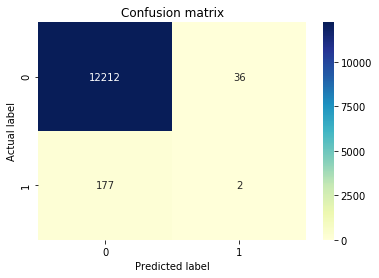

In [151]:
from sklearn import metrics

logreg=LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)
y_pred_test = logreg.predict(X_test)
y_pred_valid = logreg.predict(X_valid)


#confusion matrix
cnf_matrix_train=metrics.confusion_matrix(y_train, y_pred_train)
cnf_matrix_test=metrics.confusion_matrix(y_test, y_pred_test)
cnf_matrix_valid=metrics.confusion_matrix(y_valid, y_pred_valid)
#metrics.accuracy_score(y_test,y_pred)

#Plot confusion matrix for testing
class_names=[0,1] # name  of classes
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_valid), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(f"FRD for training is {(cnf_matrix_train[1][1]/(cnf_matrix_train[1][0]+cnf_matrix_train[1][1]))*100}%")
print(f"FRD for testing is {(cnf_matrix_test[1][1]/(cnf_matrix_test[1][0]+cnf_matrix_test[1][1]))*100}%")
print(f"FRD for validation is {(cnf_matrix_valid[1][1]/(cnf_matrix_valid[1][0]+cnf_matrix_valid[1][1]))*100}%")

## Random Forest

In [152]:
from sklearn.ensemble import RandomForestClassifier
rand_for=RandomForestClassifier(random_state=0)
rand_for.fit(X_train, y_train)
y_pred_train = rand_for.predict(X_train)
y_pred_test = rand_for.predict(X_test)
y_pred_valid = rand_for.predict(X_valid)

#confusion matrix
cnf_matrix_train=metrics.confusion_matrix(y_train, y_pred_train)
cnf_matrix_test=metrics.confusion_matrix(y_test, y_pred_test)
cnf_matrix_valid=metrics.confusion_matrix(y_valid, y_pred_valid)

print(f"FRD for training is {(cnf_matrix_train[1][1]/(cnf_matrix_train[1][0]+cnf_matrix_train[1][1]))*100}%")
print(f"FRD for testing is {(cnf_matrix_test[1][1]/(cnf_matrix_test[1][0]+cnf_matrix_test[1][1]))*100}%")
print(f"FRD for validation is {(cnf_matrix_valid[1][1]/(cnf_matrix_valid[1][0]+cnf_matrix_valid[1][1]))*100}%")

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


FRD for training is 91.18198874296435%
FRD for testing is 54.7550432276657%
FRD for validation is 17.318435754189945%


## Boosted forest

In [153]:
from sklearn.ensemble import GradientBoostingClassifier
boosted_tree=GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, random_state=0).fit(X_train, y_train)
y_pred_train = boosted_tree.predict(X_train)
y_pred_test = boosted_tree.predict(X_test)
y_pred_valid = boosted_tree.predict(X_valid)

#confusion matrix
cnf_matrix_train=metrics.confusion_matrix(y_train, y_pred_train)
cnf_matrix_test=metrics.confusion_matrix(y_test, y_pred_test)
cnf_matrix_valid=metrics.confusion_matrix(y_valid, y_pred_valid)

print(f"FRD for training is {(cnf_matrix_train[1][1]/(cnf_matrix_train[1][0]+cnf_matrix_train[1][1]))*100}%")
print(f"FRD for testing is {(cnf_matrix_test[1][1]/(cnf_matrix_test[1][0]+cnf_matrix_test[1][1]))*100}%")
print(f"FRD for validation is {(cnf_matrix_valid[1][1]/(cnf_matrix_valid[1][0]+cnf_matrix_valid[1][1]))*100}%")


FRD for training is 76.17260787992495%
FRD for testing is 57.925072046109506%
FRD for validation is 20.670391061452513%
